# Модель классификации для выбора подходящего мобильного тарифа 

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не требуется, так как была сделана ранее.
Цель работы - построить модель классификации с максимально большим значением Accuracy.

План работы
1. Открыть файл с данными и изучить его. Путь к файлу: datasets/users_behavior.csv. 
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры.
4. Проверить качество модели на тестовой выборке.
5. Дополнительное задание: проверить модели на вменяемость. 

In [1]:
# Импорт библиотек
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.dummy import DummyClassifier

## Шаг 1. Открытие файла с данными и изучение общей информации

In [2]:
df = pd.read_csv('f:/yandex-practicum/datasets/users_behavior.csv')

df.info() # просмотр размера таблицы, типов данных, количества non-null
display(df.head()) # просмотр первых строк данных
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [3]:
df.duplicated().sum() # поиск явных дубликатов

0

In [4]:
df['calls'] = df['calls'].astype(int)
df['messages'] = df['messages'].astype(int)
df.dtypes

calls         int32
minutes     float64
messages      int32
mb_used     float64
is_ultra      int64
dtype: object

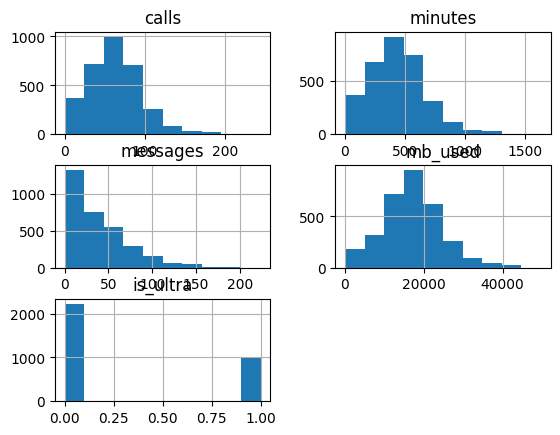

In [5]:
df.hist();

### Вывод
Данные содержат 3214 записей. Каждый строка в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
сalls — количество звонков,
minutes — суммарная длительность звонков в минутах,
messages — количество sms-сообщений,
mb_used — израсходованный интернет-трафик в Мб,
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Пропусков в данных нет. Явных дубликатов нет. Выбросов в данных нет.

Данные в столбцах calls и messages преобразованы в целочисленные. 

## Шаг 2. Подготовка данных. Разделение исходных данных на обучающую, валидационную и тестовую выборки

В качестве признаков используются минуты, сообщения, трафик. Количество звонков исключено из признаков, т.к. в явном виде не участвует в тарификации. 
Целевой признак - тариф. Обучающая, валидационная и тестовая выборки разбиваются в пропорции 3:1:1




In [6]:
features = df.drop(['is_ultra','calls'],axis=1)# признаки 
target = df['is_ultra']# целевой признак
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.20, random_state=12345)

features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=.25, random_state=12345)
print('Доли тарифа Ультра в выборках:', target_train.mean(), target_valid.mean(),target_test.mean())
 

Доли тарифа Ультра в выборках: 0.30549792531120334 0.3048211508553655 0.3110419906687403


In [7]:
# Размеры выборок
for name,i in zip(['features_train', 'features_valid', 'features_test', 'target_train','target_valid', 'target_test'],
    [features_train, features_valid, features_test, target_train,target_valid, target_test]):
    print(f'Размер выборки {name}: {i.shape}')

Размер выборки features_train: (1928, 3)
Размер выборки features_valid: (643, 3)
Размер выборки features_test: (643, 3)
Размер выборки target_train: (1928,)
Размер выборки target_valid: (643,)
Размер выборки target_test: (643,)


### Вывод
Данные (3214 записей) разбиты на 3 части тренировочную, валидационную и тестовую выборки в пропорции 3:1:1. 
признаки и целевой признак (тариф) разделены по разным переменным.
Доли каждого тарифа в разных выборках примерно равны.

## Шаг 3. Исследование качества разных моделей с разными гиперпараметрами

Создаются и анализируются модели классификации: 
- Решающее дерево
- Случайный лес
- Логистическая регрессия

### 3.1. Решающее дерево

In [8]:
# Решающее дерево
best_accuracy = 0
for splitt in ['best', 'random']:
  for criter in ['gini', 'entropy']:
    for min_samples_split_i in range(10,20):
      for depth in range (7,15):
        model = DecisionTreeClassifier(
            random_state=12345, max_depth=depth, criterion=criter, splitter=splitt,
            min_samples_split=min_samples_split_i)
        model.fit(features_train, target_train)
        accuracy = accuracy_score(target_valid, model.predict(features_valid))
        #accuracy = min(model.score(features_train, target_train), model.score(features_valid, target_valid))        
        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_tree_model = model
          best_depth = depth
          best_criterion = criter
          best_splitter = splitt
          best_min_samples_split = min_samples_split_i
#было print("Accuracy лучшей модели решающего дерева:", best_accuracy, 
#      'при максимальной глубине', best_depth, 
#      criter, best_splitter, best_min_samples_split)
print(f"Accuracy лучшей модели решающего дерева: {best_accuracy:.5f}") 
print(f"Гиперпараметры: max_depth - {best_depth}, criterion - {best_criterion}, splitter - {best_splitter}, min_samples_split - {best_min_samples_split}") 
print(f"Метрики: точность - {precision_score(target_valid, best_tree_model.predict(features_valid)):.5f}, полнота - {recall_score(target_valid, best_tree_model.predict(features_valid)):.5f}")


#0.807153965785381 при максимальной глубине 12 entropy random 11

Accuracy лучшей модели решающего дерева: 0.80715
Гиперпараметры: max_depth - 12, criterion - gini, splitter - random, min_samples_split - 11
Метрики: точность - 0.76087, полнота - 0.53571


### 3.2. Случайный лес

In [9]:
# Случайный лес
best_accuracy = 0
for n_estimator in range(2,7):
  for criter in ['gini', 'entropy']:
    for min_samples_split_i in range(7,16):
      for depth in range (5,11):
        model = RandomForestClassifier(random_state=12345, n_estimators=n_estimator,
            max_depth=depth, criterion=criter,
            min_samples_split=min_samples_split_i)
        model.fit(features_train, target_train)
        accuracy = accuracy_score(target_valid, model.predict(features_valid)) 
        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_forest_model = model
          best_depth = depth
          best_criterion = criter
          best_n_estimator = n_estimator
          best_min_samples_split = min_samples_split_i
#print("Accuracy лучшей модели случаного леса:", best_accuracy, 
#      'при максимальной глубине', best_depth, 
#      criter, best_n_estimator, best_min_samples_split)
print(f"Accuracy лучшей модели случаного леса: {best_accuracy:.5f}") 
print(f"Гиперпараметры: n_estimators - {best_n_estimator}, max_depth - {best_depth}, criterion - {best_criterion}, min_samples_split - {best_min_samples_split}") 
print(f"Метрики: точность - {precision_score(target_valid, best_forest_model.predict(features_valid)):.5f}, полнота - {recall_score(target_valid, best_forest_model.predict(features_valid)):.5f}")

#Accuracy лучшей модели случаного леса: 0.8055987558320373 при максимальной глубине 9 entropy 4 14

Accuracy лучшей модели случаного леса: 0.80560
Гиперпараметры: n_estimators - 4, max_depth - 9, criterion - entropy, min_samples_split - 14
Метрики: точность - 0.77519, полнота - 0.51020


### 3.3. Логистическая регрессия

In [10]:
#Логистическая регрессия
best_accuracy = 0
#for penalty in ['l1', 'l2', 'elasticnet', 'none']:
for solver in ['lbfgs', 'liblinear']:# ,'newton-cg'  ,'sag', 'saga'
  for max_iter in range(100,150,10):
    model = LogisticRegression(random_state=12345, solver=solver, max_iter=max_iter)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    #accuracy = min(model.score(features_train, target_train), model.score(features_valid, target_valid))
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_regression_model = model
      best_solver = solver
      best_max_iter = max_iter
#print("Accuracy лучшей модели логистической регрессии:", best_accuracy, best_solver, 
#      best_max_iter)
print(f"Accuracy лучшей модели логистической регрессии: {best_accuracy:.5f}") 
print(f"Гиперпараметры: solver - {best_solver}, max_iter - {best_max_iter}") 
print(f"Метрики: точность - {precision_score(target_valid, best_regression_model.predict(features_valid)):.5f}, полнота - {recall_score(target_valid, best_regression_model.predict(features_valid)):.5f}")


Accuracy лучшей модели логистической регрессии: 0.75894
Гиперпараметры: solver - lbfgs, max_iter - 100
Метрики: точность - 0.88679, полнота - 0.23980


### Вывод
Для моделей Решающее дерево, Случайный лес, Логистическая регрессия подобраны гиперпараметры максимизирующие качество модели на валидационной выборке.
Наилучшее качество модели (accuracy = 0.807) наблюдается у решающего дерева
с параметрами max_depth=12, criterion=entropy, splitter='random', min_samples_split=11, для Случайного леса наилучшее качество модели (accuracy = 0.8056) при гиперпараметрах n_estimators=4, max_depth=9, criterion=entropy, min_samples_split=14.
случайные ответы дадут accuracy = 0.5, созданные модели качественнее  

## Шаг 4. Проверка качества моделей на тестовой выборке

Рассматриваются модели: 
- Решающее дерево
- Случайный лес
- Логистическая регрессия

In [11]:
print("Accuracy тестовой выборки лучшей модели решающего дерева:", best_tree_model.score(features_test, target_test))
print("Accuracy тестовой выборки лучшей модели случайного леса:", best_forest_model.score(features_test, target_test))
print("Accuracy тестовой выборки лучшей модели логистической регрессии:", best_regression_model.score(features_test, target_test))

print('Точность (tp / (tp + fp)):',
      precision_score(target_test, best_tree_model.predict(features_test)),
      precision_score(target_test, best_forest_model.predict(features_test)),
      precision_score(target_test, best_regression_model.predict(features_test)))

print('Полнота (tp / (tp + fn)):',
      recall_score(target_test, best_tree_model.predict(features_test)),
      recall_score(target_test, best_forest_model.predict(features_test)),
      recall_score(target_test, best_regression_model.predict(features_test)))


Accuracy тестовой выборки лучшей модели решающего дерева: 0.7729393468118196
Accuracy тестовой выборки лучшей модели случайного леса: 0.7807153965785381
Accuracy тестовой выборки лучшей модели логистической регрессии: 0.7262830482115086
Точность (tp / (tp + fp)): 0.684931506849315 0.7322834645669292 0.74
Полнота (tp / (tp + fn)): 0.5 0.465 0.185


### Вывод
Для моделей Решающее дерево и Случайный лес при сравнимых accuracy на валидационных выборках, качество моделей на тестовых выборках немного ниже и составляет 0,7729 и 0,7807 соответственно. Для логистической регрессии качество модели ниже: на валидационной - 0,7589, на тестовой - 0,7262


## Шаг 5. Проверка вменяемости модели
Проверка адекватности модели, анализ результатов предсказаний

In [12]:
# доли классов целевого признака
print (target_test.value_counts(normalize=True))
# предсказание константной модели

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
dummy_clf.predict(features_test)
print(f"Accuracy константной модели: {accuracy_score(target_test,dummy_clf.predict(features_test)):.3f}") 

0    0.688958
1    0.311042
Name: is_ultra, dtype: float64
Accuracy константной модели: 0.689


Accuracy обученной и улучшеной модели случайного леса (0,78) превышает accuracy константой модели (0,69) на 0,09. 
    
Целесообразно предсказывать клиентов, которым может подойти более дорогой тариф, т.е. "1" в целевом признаке. Точность и полнота предсказаний для случайного леса  0.732 и  0.465 , т.е. 73% предсказаний о переходе на дорогой тариф верны, 27 процентам предсказаных клиентов дорогой тариф не подойдет. Из всех клиентов, которым может подойти дорогой тариф, модель предсказывает только 46,5%.


Для проверки корректности результатов предсказаний моделей решающего дерева и случайного леса используются записи с максимальными затратами минут смс и трафика для каждого тарифа

Описание тарифов
- Тариф «Смарт»
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Ежемесячная плата: 550 рублей. Стоимость услуг сверх тарифного пакета: минута разговора- 3 рубля, сообщение- 3 рубля, 1 Гб интернет-трафика- 200 рублей
- Тариф «Ультра»
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Ежемесячная плата: 1950 рублей. Стоимость услуг сверх тарифного пакета:
минута разговора - 1 рубль
сообщение - 1 рубль
1 Гб интернет-трафика - 150 рублей

In [13]:
features_ultra = pd.DataFrame({'minutes':[0, 0, 3000,3000,1500], 'messages':[0, 1000, 0,1000,500], 'mb_used':[30720, 0, 0,30720,15360]})
print(best_forest_model.predict(features_ultra), best_tree_model.predict(features_ultra), best_regression_model.predict(features_ultra))


[1 1 1 1 1] [1 0 1 1 1] [0 1 1 1 1]


In [14]:
features_smart = pd.DataFrame({'minutes':[0, 0, 500,500,250], 'messages':[0, 50, 0,50,25], 'mb_used':[15360, 0, 0,15360,7680]})
print(best_forest_model.predict(features_smart), best_tree_model.predict(features_smart), best_regression_model.predict(features_smart))


[1 1 1 0 0] [0 1 1 0 0] [0 0 0 0 0]


### Вывод
Для проверки адекватности модели получена метрика константной модели, которая совпадает с долей частого класса и равняется 0.69.

Дополнительно для анализа корректности результатов работы модели предсказаны тарифы для характерных использований услуг связи: 
1-3. полностью использован лимит одной из услуг тарифа; 4. полностью использован лимит всех услуг тарифа; 5. использована половина лимита каждой услуги.
В результате анализа установлено: 
- модель случайного леса при полном использовании только одной из 3х услуг тарифа Смарт рекомендует перейти на тариф Ультра, что не может считаться корректной рекомендацией, однако при использовании всех услуг пакета (полностью или половины) правильно рекомендует использовать тариф Смарт.
- модель решающего дерева имеет схожие проблемы: при полном использовании сообщений или минут пакета смарт некорректно рекомендует перейти на тариф Ультра, при полном использовании пакета сообщений тарифа Ультра некорректно рекомендует перейти на тариф Смарт.
- модель логистической регрессии выдает наиболее адекватные рекомендации, но некорректно рекомендует перейти на смарт только при использовании полного  пакета интернета тарифа Ультра

## Шаг 6. Общий вывод


В ходе разработки модели классификации для выбора подходящего тарифа оператора "Мегалайн" было выполнено: 
1. Открыт и изучен файл с данными.
2. Исходные данные разделены на обучающую, валидационную и тестовую выборки в пропорции 3:1:1. Выделены признаки: количество минут, сообщений и интернет трафика. Выделен целевой признак - тариф.
3. Построены модели классификации: решающее дерево, случайный лес, логистическая регрессия. Исследовано влияние гиперпараметров на качество моделй. Выбраны наилучшие модели в каждом классе. 
4. Проверено качество моделей на тестовой выборке. 
5. Модели проверены на адекватность. Качество всех разработанных моделей выше качества константной модели.

Дополнительно для анализа корректности результатов работы модели предсказаны тарифы для характерных использований услуг связи: 
1-3. полностью использован лимит одной из услуг тарифа; 4. полностью использован лимит всех услуг тарифа; 5. использована половина лимита каждой услуги.
В результате анализа установлено: 
- модель случайного леса при полном использовании только одной из 3х услуг тарифа Смарт рекомендует перейти на тариф Ультра, что не может считаться корректной рекомендацией, однако при использовании всех услуг пакета (полностью или половины) правильно рекомендует использовать тариф Смарт.
- модель решающего дерева имеет схожие проблемы: при полном использовании сообщений или минут пакета смарт некорректно рекомендует перейти на тариф Ультра, при полном использовании пакета сообщений тарифа Ультра некорректно рекомендует перейти на тариф Смарт.
- модель логистической регрессии выдает наиболее адекватные рекомендации, но некорректно рекомендует перейти на смарт только при использовании полного  пакета интернета тарифа Ультра

Итак, модели Решающее дерево и Случайный лес имеют сравнимые accuracy на валидационной выборке - (0.8072 и 0.8056) и на тестовой выборке - (0,7729 и 0,7807 соответственно). Для логистической регрессии качество модели заметно ниже: на валидационной - 0,7589, на тестовой - 0,7262. При этом качество всех разработанных моделей выше качества константной модели (0.69).

Рекомендуемая модель - модель решающего дерева (с наибольшим accuracy на валидационной выборке) с гиперпараметрами: max_depth - 12, criterion - gini, splitter - random, min_samples_split - 11. Однако в ее работе прослеживаются некорректные рекомендации: при полном использовании сообщений(1) или минут(2) пакета Смарт некорректно рекомендуется переход на тариф Ультра, а при полном использовании только пакета сообщений(3) тарифа Ультра - переход на тариф Смарт. При этом финансовые затраты от таких рекомендаций могут сокращаться, например, для рекомендации (3) оплата сократиться на 450 р., но построенная модель обучалась только на поведении пользователей, и ничего не знает о деньгах. Поэтому для улучшения предсказаний можно учесть стоимости тарифов и услуг сверх тарифа.
